#Przegląd

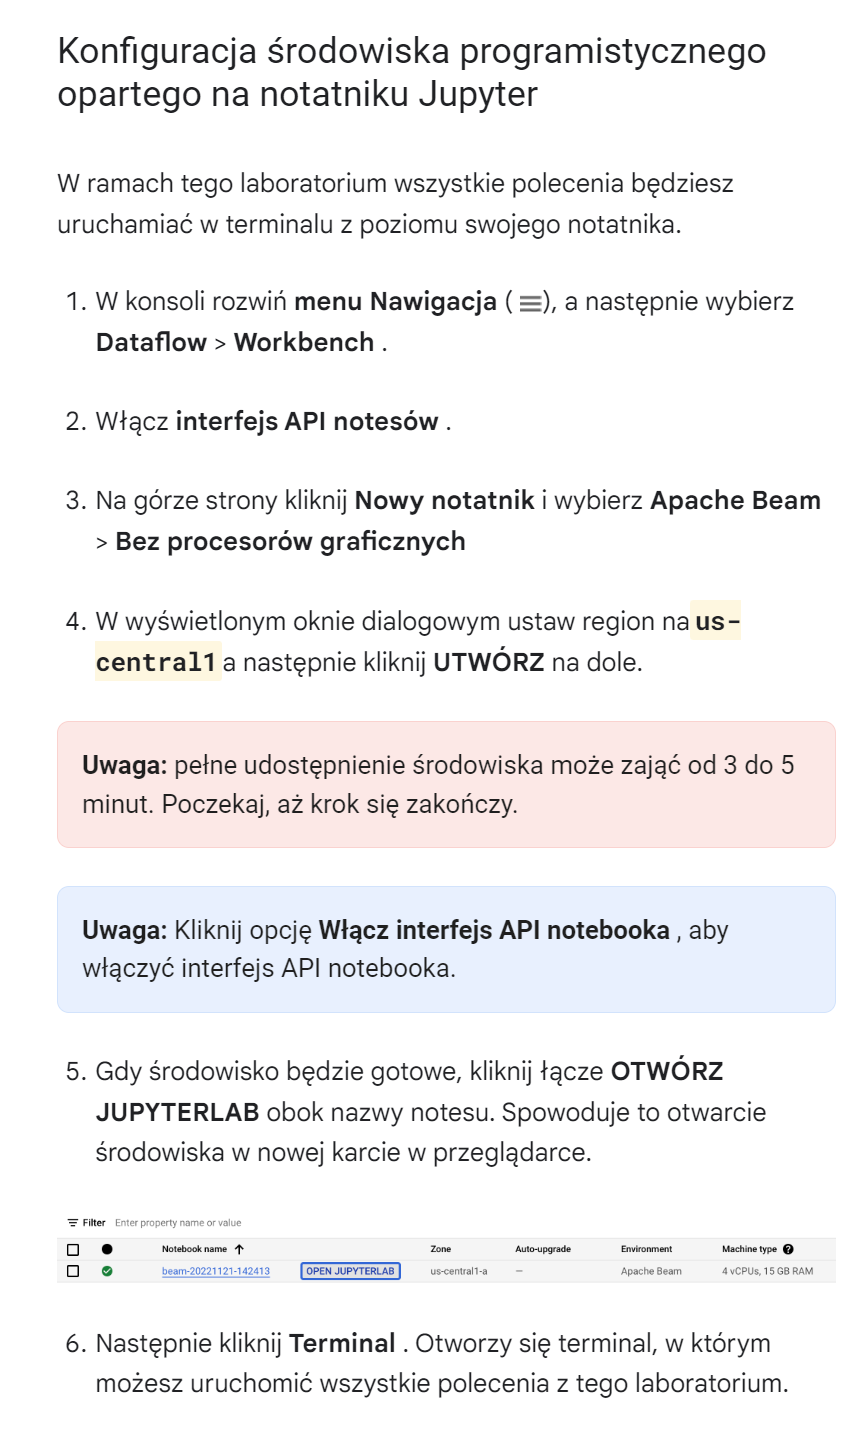

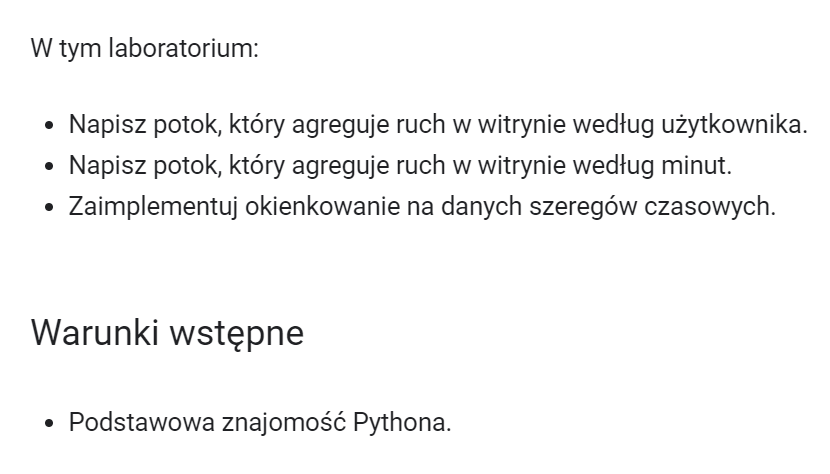

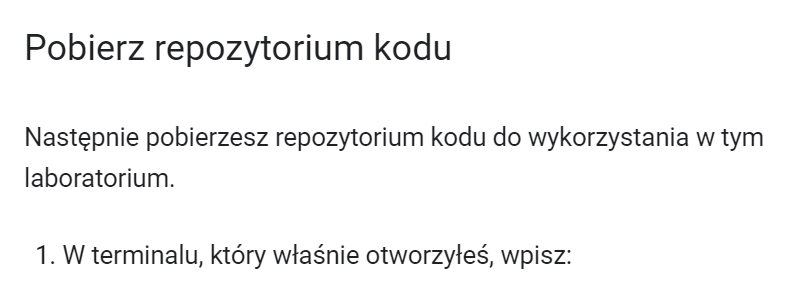

In [ ]:
git clone https://github.com/GoogleCloudPlatform/training-data-analyst

In [ ]:
cd /home/jupyter/training-data-analyst/quests/dataflow_python/

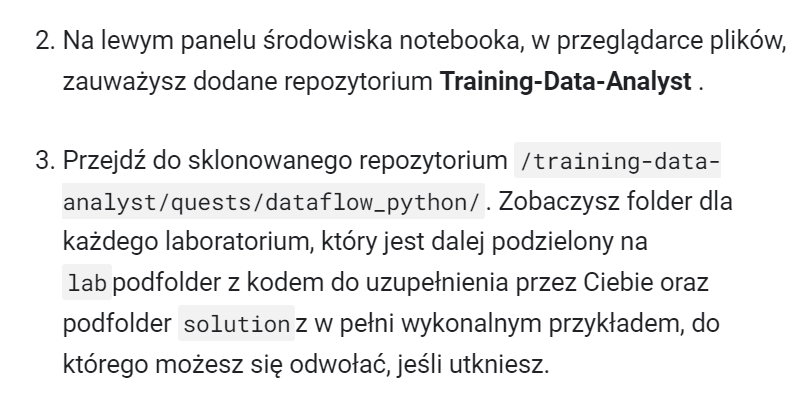

#Część 1. Agregacja ruchu w witrynie według użytkownika

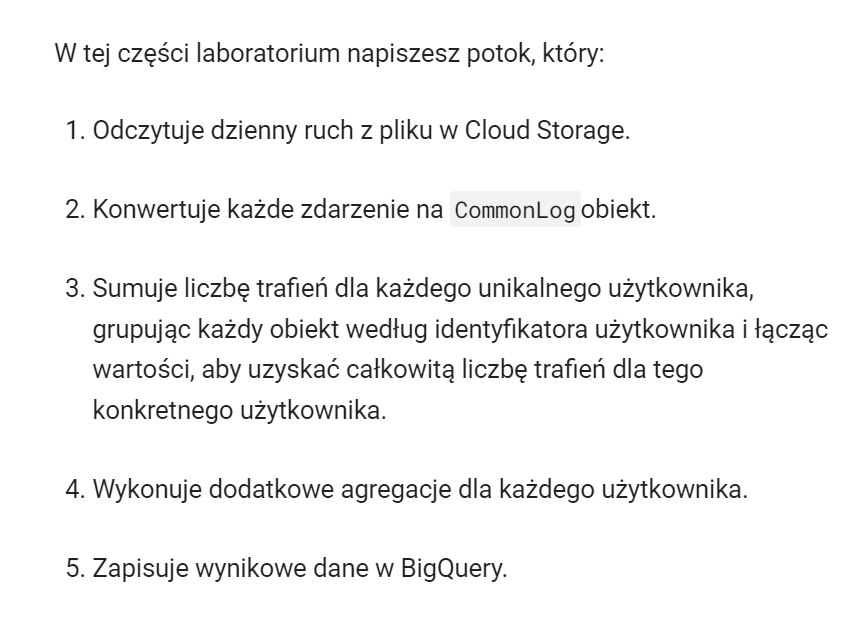

##Zadanie 1. Wygeneruj dane syntetyczne

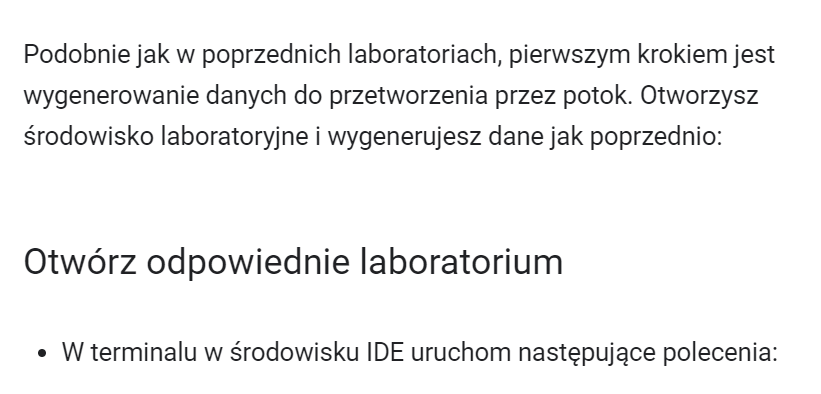

In [ ]:
# Change directory into the lab
cd 3_Batch_Analytics/lab
export BASE_DIR=$(pwd)

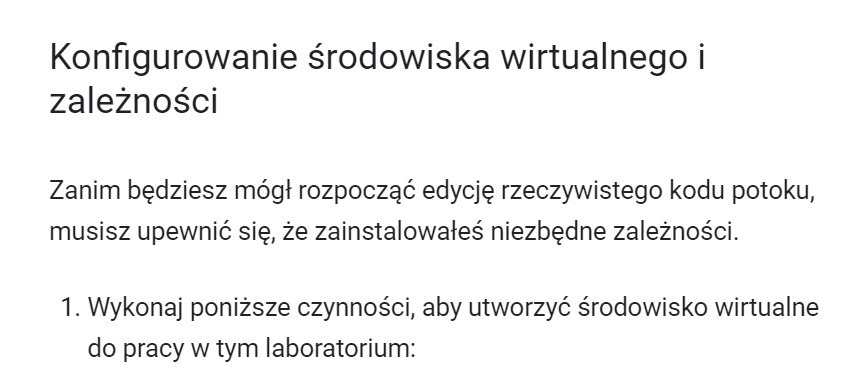

In [ ]:
sudo apt-get update && sudo apt-get install -y python3-venv

In [ ]:
# Create and activate virtual environment
python3 -m venv df-env

In [ ]:
source df-env/bin/activate

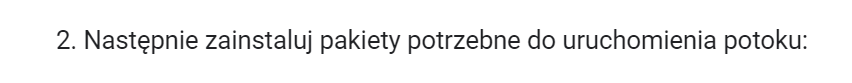

In [ ]:
python3 -m pip install -q --upgrade pip setuptools wheel

In [ ]:
python3 -m pip install apache-beam[gcp]

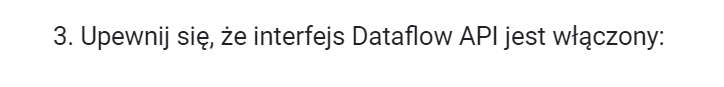

In [ ]:
gcloud services enable dataflow.googleapis.com

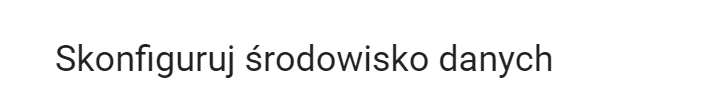

In [ ]:
# Create GCS buckets and BQ dataset
cd $BASE_DIR/../..
source create_batch_sinks.sh

create_batch_sinks.sh

In [ ]:
#!/bin/#!/usr/bin/env bash
echo "Creating pipeline sinks"

PROJECT_ID=$(gcloud config get-value project)

# GCS buckets
#TODO: Add try/catch for the first bucket since qwiklabs
gsutil mb -l US gs://$PROJECT_ID
gsutil mb -l US -c "COLDLINE" gs://$PROJECT_ID-coldline

# BiqQuery Dataset
bq mk --location=US logs

In [ ]:
# Generate event dataflow
source generate_batch_events.sh

generate_batch_events.sh

In [ ]:
#!/bin/#!/usr/bin/env bash
echo "Installing packages"
# Install modules
sh ./install_packages.sh

echo "Generating synthetic users"
# Generate 2 fake web site users
python3 user_generator.py --n=10

echo "Generating synthetic events"
rm *.out 2> /dev/null
# Generate 10 events
python3 batch_event_generator.py --num_e=1000

echo "Copying events to Cloud Storage"
# Set BUCKET to the non-coldline Google Cloud Storage bucket
export BUCKET=gs://$(gcloud config get-value project)/
# Copy events.json into the bucket
gsutil cp events.json ${BUCKET}

install_packages.sh

In [ ]:
#/bin/sh
pip3 install -q anytree
pip3 install -q --upgrade google-cloud-pubsub
pip3 install -q faker
pip3 install -q --upgrade geocoder

In [ ]:
# Change to the directory containing the practice version of the code
cd $BASE_DIR

user_generator.py

In [ ]:
# Generates random users for a website

import argparse
from faker import Faker
import geocoder
from random import choice

parser = argparse.ArgumentParser(__file__, description="Web Server Data Generator")
parser.add_argument("--num_users", "-u", type=int, dest="num_users",
                    help="The number of users to create", default=100)

args = parser.parse_args()
num_users = int(args.num_users)

faker = Faker()
# A list of functions for generating user agent strings for various browsers
ualist = [faker.firefox, faker.chrome, faker.safari, faker.internet_explorer, faker.opera]

sensitive_fields = ['lat', 'lng', 'ip', 'user_agent']

def generate_user():
    """
    Returns a randomly generate dictionary representing a user, where each user is described by
    a user agent string, an ID, a latlng, an IP, an age_bracket, whether they've oped into marketing
    and the
    :return:
    """
    user = {}
    user['lat'] = ""
    user['lng'] = ""
    while user['lat'] == "" or user['lng'] == "":
        user['ip'] = faker.ipv4()
        g = geocoder.ip(user['ip'])
        latlng = list(map(str, g.latlng))
        if len(latlng) == 2:
            user['lat'] = latlng[0]
            user['lng'] = latlng[1]
    user['user_agent'] = choice(ualist)()
    user['age_bracket'] = choice(['18-25', '26-40', '41-55', '55+'])
    user['opted_into_marketing'] = choice([True, False])
    user['id'] = hash(str(user['ip']) + str(user['lat'] + str(user['lng'])))
    return user

def write_csvs(users):
    """
    Writes two .csv files, one for ingestiong by an event generator, the other formatted to be uploaded to BigQuery
    :param users:
    :return:
    """
    with open("users.csv", 'w') as event_out, open("users_bq.txt", 'w') as bq_out:
            cols = list(users[0].keys())
            cols.sort()
            bq_cols = cols.copy()
            [bq_cols.remove(s) for s in sensitive_fields]
            event_out.write(",".join(cols) + '\n')
            for user in users:
                event_vals = [str(user[key]) for key in cols]
                event_out.write(",".join(event_vals) + '\n')
                bq_vals = [str(user[key]) for key in bq_cols]
                bq_out.write(",".join(bq_vals) + '\n')

if __name__ == '__main__':
    users = [generate_user() for i in range(num_users)]
    write_csvs(users)


batch_event_generator.py

In [ ]:
# This program reads a file representing web server logs in common log format and streams them into a PubSub topic
# with lag characteristics as determined by command-line arguments

import argparse
import time, glob
from datetime import datetime, timezone, timedelta
import random
from anytree.importer import DictImporter
import json
from multiprocessing import Process, Value, Lock
from copy import deepcopy
import os
from signal import SIGKILL

parser = argparse.ArgumentParser(__file__, description="event_generator")
parser.add_argument("--taxonomy", "-x", dest="taxonomy_fp",
                    help="A .json file representing a taxonomy of web resources",
                    default="taxonomy.json")
parser.add_argument("--users_fp", "-u", dest="users_fp",
                    help="A .csv file of users",
                    default="users.csv")
parser.add_argument("--num_e", "-e", dest="max_num_events", type=int,
                    help="The maximum number of events to generate before " \
                    " stopping. Defaults to None, which means run" \
                    " indefinitely", default=1000)
parser.add_argument("--off_to_on", "-off", dest="off_to_on_prob", type=float,
                    help="A float representing the probability that a user who is offline will come online",
                    default=.25)
parser.add_argument("--on_to_off", "-on", dest="on_to_off_prob", type=float,
                    help="A float representing the probability that a user who is online will go offline",
                    default=.1)

page_read_secs = 5
args = parser.parse_args()
taxonomy_fp = args.taxonomy_fp
users_fp = args.users_fp
max_num_events = args.max_num_events
online_to_offline_probability = args.on_to_off_prob
offline_to_online_probability = args.off_to_on_prob

min_file_size_bytes = 100
max_file_size_bytes = 500
verbs = ["GET"]
responses = [200]


log_fields = ["ip", "user_id", "lat", "lng", "timestamp", "http_request", "http_response", "num_bytes", "user_agent"]

def extract_resources(taxonomy_filepath):
    """
    Reads a .json representing a taxonomy and returns
    a data structure representing their hierarchical relationship
    :param taxonomy_file: a string representing a path to a .json file
    :return: Node representing root of taxonomic tree
    """

    try:
        with open(taxonomy_filepath, 'r') as fp:
            json_str = fp.read()
            json_data = json.loads(json_str)
            root = DictImporter().import_(json_data)
    finally:
        fp.close()

    return root


def read_users(users_fp):
    """
    Reads a .csv from @user_fp representing users into a list of dictionaries,
    each elt of which represents a user
    :param user_fp: a .csv file where each line represents a user
    :return: a list of dictionaries
    """
    users = []
    with open(users_fp, 'r') as fp:
        fields = fp.readline().rstrip().split(",")
        for line in fp:
            user = dict(zip(fields, line.rstrip().split(",")))
            users.append(user)
    return users

def publish_burst(burst, num_events_counter, fp):
    """
    Publishes and prints each event
    :param burst: a list of dictionaries, each representing an event
    :param num_events_counter: an instance of Value shared by all processes to
    track the number of published events
    :param publisher: a PubSub publisher
    :param topic_path: a topic path for PubSub
    :return:
    """
    for event_dict in burst:
        json_str = json.dumps(event_dict)
        num_events_counter.value += 1
        fp.write(json_str + '\n')

def create_user_process(user, root, num_events_counter):
    """
    Code for continuously-running process representing a user publishing
    events to pubsub
    :param user: a dictionary representing characteristics of the user
    :param root: an instance of AnyNode representing the home page of a website
    :param num_events_counter: a variable shared among all processes used to track the number of events published
    :return:
    """

    user['page'] = root
    user['is_online'] = True
    user['offline_events'] = []
    user['time'] = datetime.now()
    while True:
        fp = open(str(os.getpid()) + ".out", "a")
        read_time_secs = random.uniform(0, page_read_secs * 2)
        user['time'] += timedelta(seconds=read_time_secs)
        prob = random.random()
        event = generate_event(user)
        if user['is_online']:
            if prob < online_to_offline_probability:
                user['is_online'] = False
                user['offline_events'] = [event]
            else:
                publish_burst([event], num_events_counter, fp)
        else:
            user['offline_events'].append(event)
            if prob < offline_to_online_probability:
                user['is_online'] = True
                publish_burst(user['offline_events'], num_events_counter, fp)
                user['offline_events'] = []
        fp.close()

def generate_event(user):
    """
    Returns a dictionary representing an event
    :param user:
    :return:
    """
    user['page'] = get_next_page(user)
    uri = str(user['page'].name)
    event_time = user['time']
    current_time_str = event_time.strftime('%Y-%m-%dT%H:%M:%S.%fZ')
    file_size_bytes = random.choice(range(min_file_size_bytes, max_file_size_bytes))
    http_request = "\"{} {} HTTP/1.0\"".format(random.choice(verbs), uri)
    http_response = random.choice(responses)
    event_values = [user['ip'], user['id'], float(user['lat']), float(user['lng']), current_time_str, http_request,
                    http_response, file_size_bytes, user['user_agent']]

    return dict(zip(log_fields, event_values))

def get_next_page(user):
    """
    Consults the user's representation of the web site taxonomy to determine the next page that they visit
    :param user:
    :return:
    """
    possible_next_pages = [user['page']]
    if not user['page'].is_leaf:
        possible_next_pages += list(user['page'].children)
    if (user['page'].parent != None):
        possible_next_pages += [user['page'].parent]
    next_page = random.choice(possible_next_pages)
    return next_page


if __name__ == '__main__':
    num_events_counter = Value('i', 0)
    users = read_users(users_fp)
    root = extract_resources(taxonomy_fp)
    processes = [Process(target=create_user_process, args=(deepcopy(user), deepcopy(root), num_events_counter))
                 for user in users]
    [process.start() for process in processes]
    while num_events_counter.value <= max_num_events:
        time.sleep(1)
    [os.kill(process.pid, SIGKILL) for process in processes]
    filenames = glob.glob('*.out')
    outfilename = "events.json"
    with open(outfilename, 'w+') as outfile:
        for fname in filenames:
            with open(fname, 'r') as readfile:
                infile = readfile.read()
                for line in infile:
                    outfile.write(line)

    # Iterate over the list of filepaths & remove each file.
    for filePath in filenames:
        try:
            os.remove(filePath)
        except:
            print("Error while deleting file : ", filePath)

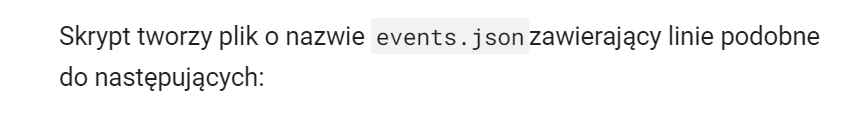

In [ ]:
{"user_id": "-6434255326544341291", "ip": "192.175.49.116", "timestamp": "2019-06-19T16:06:45.118306Z", "http_request": "\"GET eucharya.html HTTP/1.0\"", "lat": 37.751, "lng": -97.822, "http_response": 200, "user_agent": "Mozilla/5.0 (compatible; MSIE 7.0; Windows NT 5.01; Trident/5.1)", "num_bytes": 182}

#Zadanie 2. Zsumuj odsłony strony na użytkownika

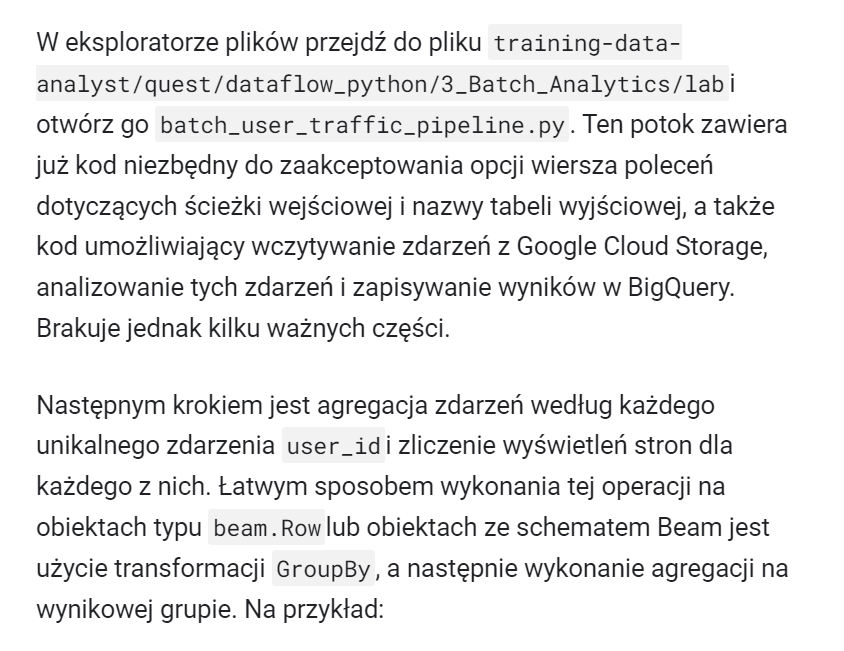

In [ ]:
purchases | GroupBy('user_id', 'address')

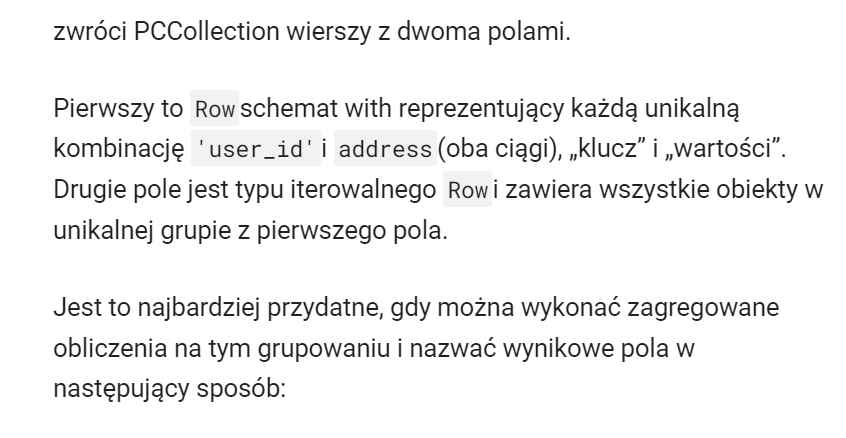

In [ ]:
(purchases | GroupBy('user_id')
             .aggregate_field("item_id", CountCombineFn(), "num_purchases")
             .aggregate_field("cost_cents", sum, "total_spend_cents")
             .aggregate_field("cost_cents", max, "largest_purchases"))
             .with_output_types(UserPurchases)

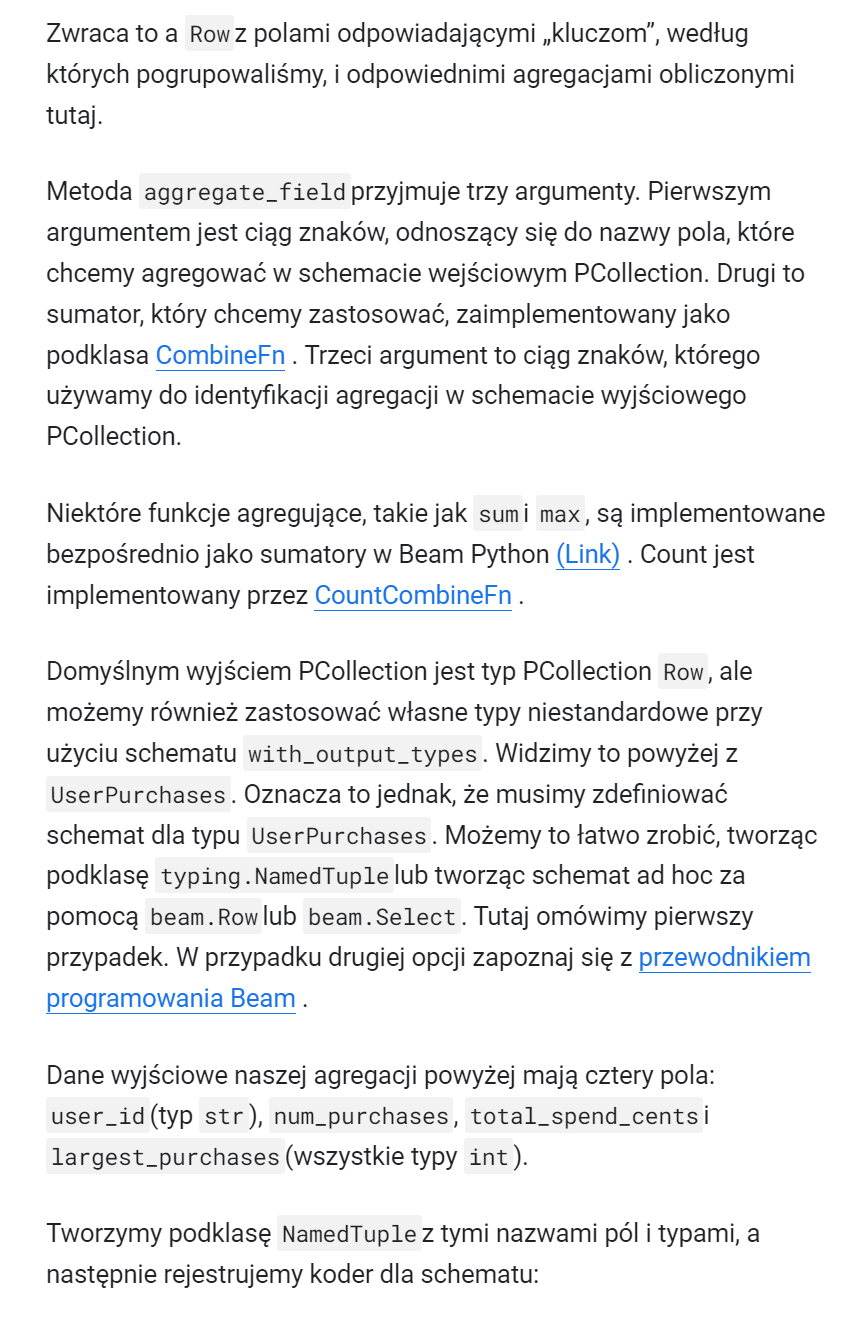

In [ ]:
class UserPurchases(typing.NamedTuple):
  user_id : str
  num_purchases : int
  total_spend_cents : int
  largest_purchases : int

beam.coders.registry.register_coder(UserPurchases, beam.coders.RowCoder)

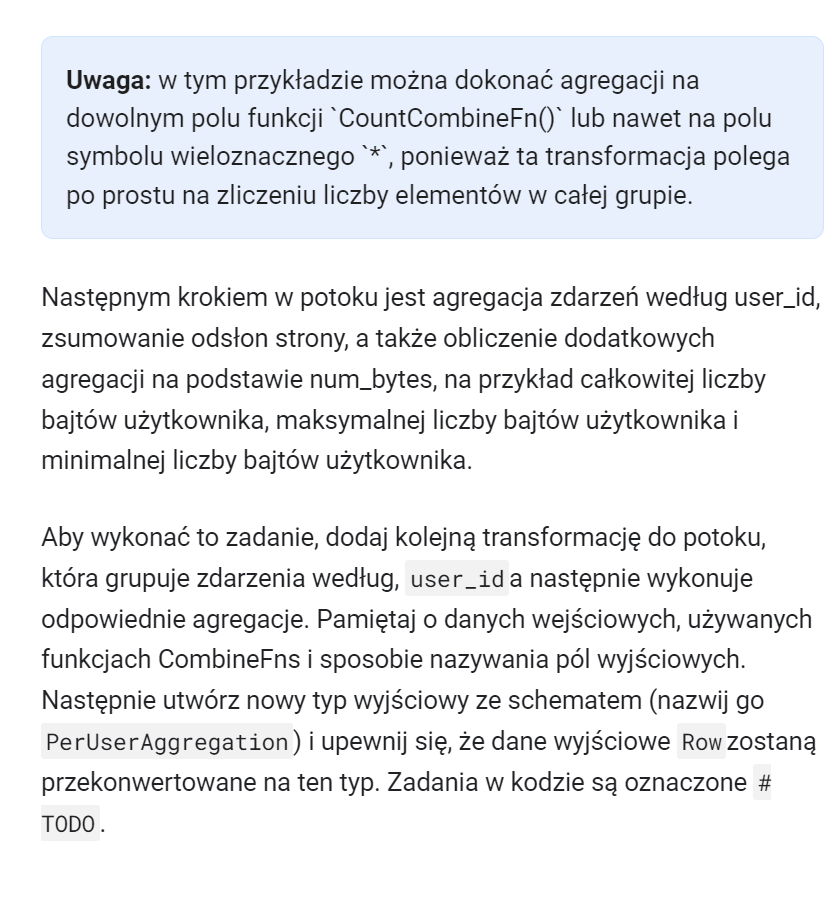

batch_user_traffic_pipeline.py

In [ ]:
import argparse
import time
import logging
import json
import typing
import apache_beam as beam
from apache_beam.options.pipeline_options import GoogleCloudOptions
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.options.pipeline_options import StandardOptions
from apache_beam.transforms.combiners import CountCombineFn
from apache_beam.runners import DataflowRunner, DirectRunner

# ### functions and classes

class CommonLog (typing.NamedTuple):
    ip: str
    user_id: str
    lat: float
    lng: float
    timestamp: str
    http_request: str
    http_response: int
    num_bytes: int
    user_agent: str

class PerUserAggregation(typing.NamedTuple):
    user_id: str
    page_views: int
    total_bytes: int
    max_bytes: int
    min_bytes: int

beam.coders.registry.register_coder(CommonLog, beam.coders.RowCoder)
beam.coders.registry.register_coder(PerUserAggregation, beam.coders.RowCoder)

def parse_json(element):
    row = json.loads(element)
    return CommonLog(**row)

def to_dict(element):
    return element._asdict()


# ### main

def run():
    # Command line arguments
    parser = argparse.ArgumentParser(description='Load from Json into BigQuery')
    parser.add_argument('--project',required=True, help='Specify Google Cloud project')
    parser.add_argument('--region', required=True, help='Specify Google Cloud region')
    parser.add_argument('--staging_location', required=True, help='Specify Cloud Storage bucket for staging')
    parser.add_argument('--temp_location', required=True, help='Specify Cloud Storage bucket for temp')
    parser.add_argument('--runner', required=True, help='Specify Apache Beam Runner')
    parser.add_argument('--input_path', required=True, help='Path to events.json')
    parser.add_argument('--table_name', required=True, help='BigQuery table name')

    opts = parser.parse_args()

    # Setting up the Beam pipeline options
    options = PipelineOptions(save_main_session=True)
    options.view_as(GoogleCloudOptions).project = opts.project
    options.view_as(GoogleCloudOptions).region = opts.region
    options.view_as(GoogleCloudOptions).staging_location = opts.staging_location
    options.view_as(GoogleCloudOptions).temp_location = opts.temp_location
    options.view_as(GoogleCloudOptions).job_name = '{0}{1}'.format('batch-user-traffic-pipeline-',time.time_ns())
    options.view_as(StandardOptions).runner = opts.runner

    input_path = opts.input_path
    table_name = opts.table_name

    # Table schema for BigQuery
    table_schema = {
        "fields": [

            {
                "name": "user_id",
                "type": "STRING"
            },
            {
                "name": "page_views",
                "type": "INTEGER"
            },
            {
                "name": "total_bytes",
                "type": "INTEGER"
            },
            {
                "name": "max_bytes",
                "type": "INTEGER"
            },
            {
                "name": "min_bytes",
                "type": "INTEGER"
            },
        ]
    }

    # Create the pipeline
    p = beam.Pipeline(options=options)



    (p | 'ReadFromGCS' >> beam.io.ReadFromText(input_path)
       | 'ParseJson' >> beam.Map(parse_json).with_output_types(CommonLog)
       | 'PerUserAggregations' >> beam.GroupBy('user_id')
                                      .aggregate_field('user_id', CountCombineFn(), 'page_views')
                                      .aggregate_field('num_bytes', sum, 'total_bytes')
                                      .aggregate_field('num_bytes', max, 'max_bytes')
                                      .aggregate_field('num_bytes', min, 'min_bytes')
                                      .with_output_types(PerUserAggregation)
       | 'ToDict' >> beam.Map(to_dict)
       | 'WriteToBQ' >> beam.io.WriteToBigQuery(
            table_name,
            schema=table_schema,
            create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,
            write_disposition=beam.io.BigQueryDisposition.WRITE_TRUNCATE
            )
    )

    logging.getLogger().setLevel(logging.INFO)
    logging.info("Building pipeline ...")

    p.run()

if __name__ == '__main__':
  run()


##Zadanie 3. Uruchom potok

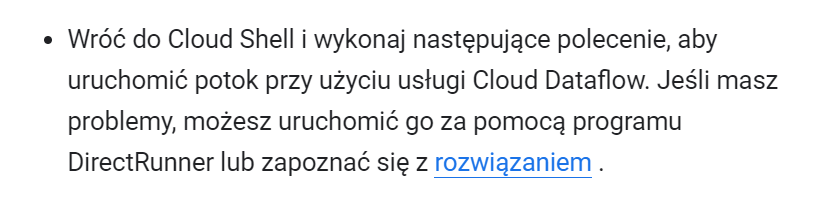

In [ ]:
export PROJECT_ID=$(gcloud config get-value project)
export REGION=us-central1
export BUCKET=gs://${PROJECT_ID}
export PIPELINE_FOLDER=${BUCKET}
export RUNNER=DataflowRunner
export INPUT_PATH=${PIPELINE_FOLDER}/events.json
export TABLE_NAME=${PROJECT_ID}:logs.user_traffic

cd $BASE_DIR
python3 batch_user_traffic_pipeline.py \
--project=${PROJECT_ID} \
--region=${REGION} \
--staging_location=${PIPELINE_FOLDER}/staging \
--temp_location=${PIPELINE_FOLDER}/temp \
--runner=${RUNNER} \
--input_path=${INPUT_PATH} \
--table_name=${TABLE_NAME}

##Zadanie 4. Zweryfikuj wyniki w BigQuery

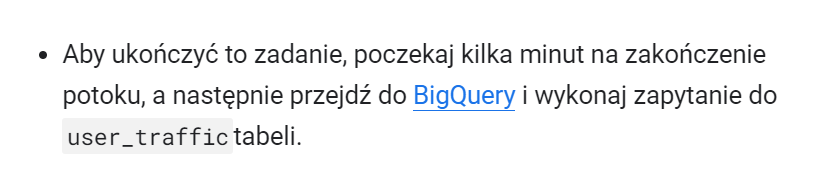

#Część 2. Agregowanie ruchu w witrynie według minut

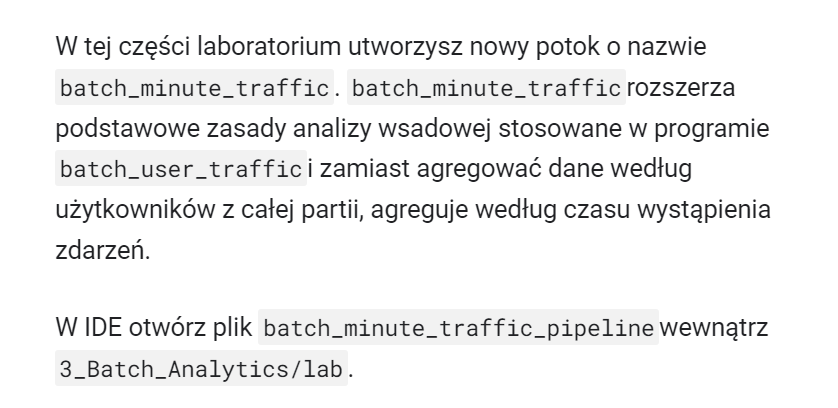

##Zadanie 5. Dodaj znaczniki czasu do każdego elementu

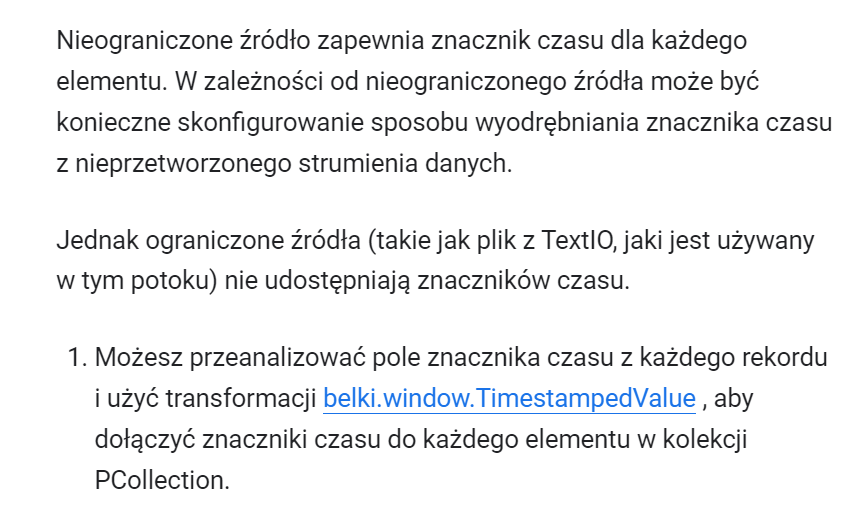

In [ ]:
def add_timestamp(element):
  ts = # Do Something
  return beam.window.TimestampedValue(element, ts)

unstamped = ...
stamped = unstamped | beam.Map(add_timestamp)

https://beam.apache.org/releases/pydoc/2.28.0/apache_beam.transforms.window.html#apache_beam.transforms.window.TimestampedValue

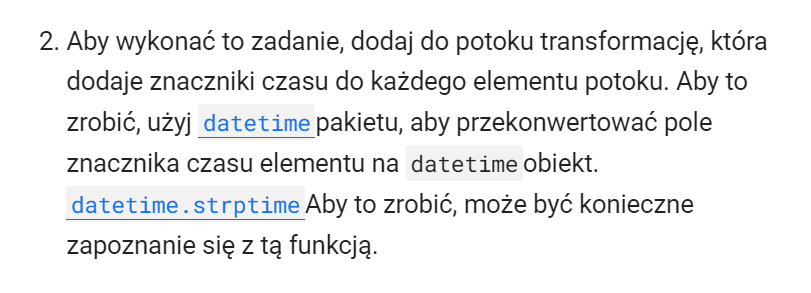

https://docs.python.org/3/library/datetime.html

##Zadanie 6. Okno na okna jednominutowe

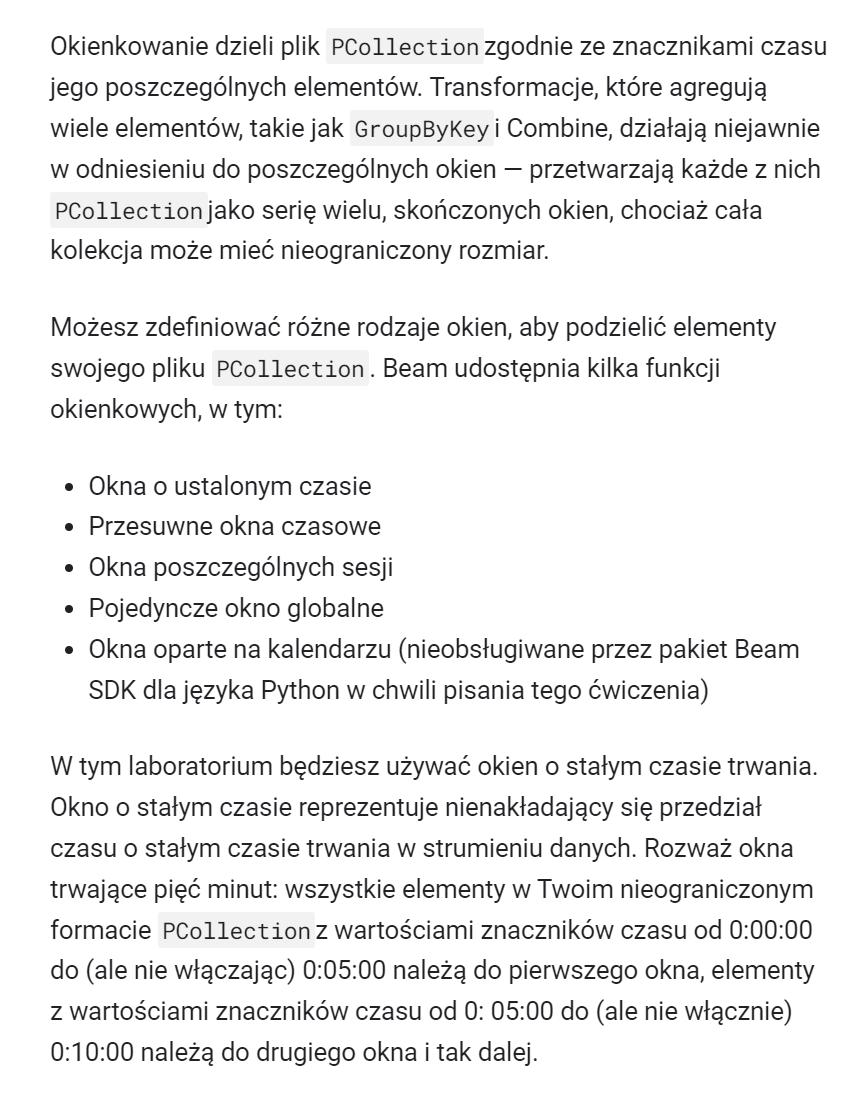

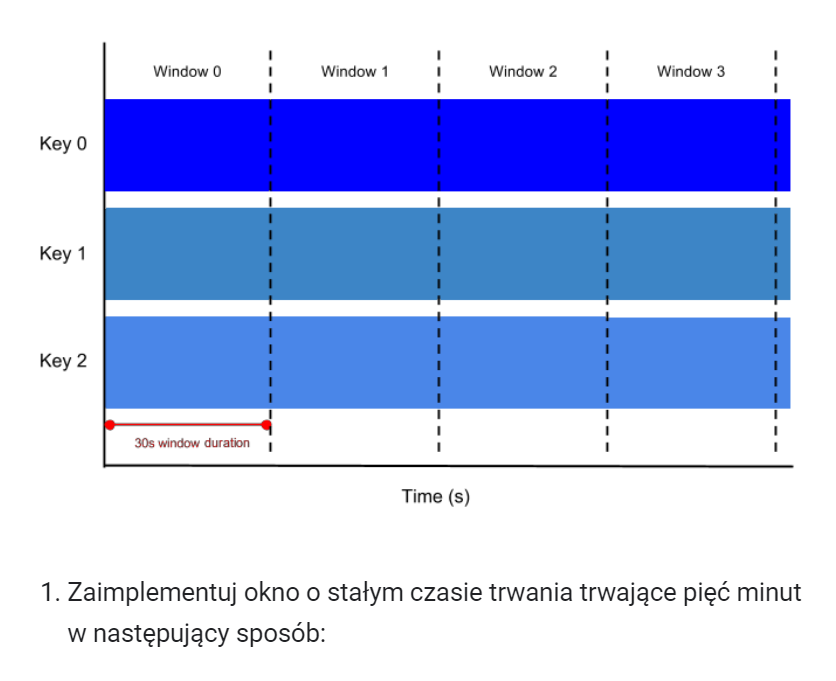

In [ ]:
p = ...
p_windowed = p | beam.WindowInto(beam.window.FixedWindows(5*60))

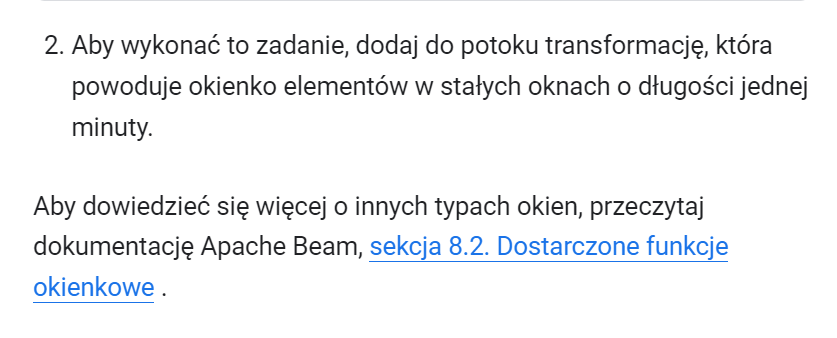

https://beam.apache.org/documentation/programming-guide/#provided-windowing-functions

##Zadanie 7. Zlicz zdarzenia w każdym oknie

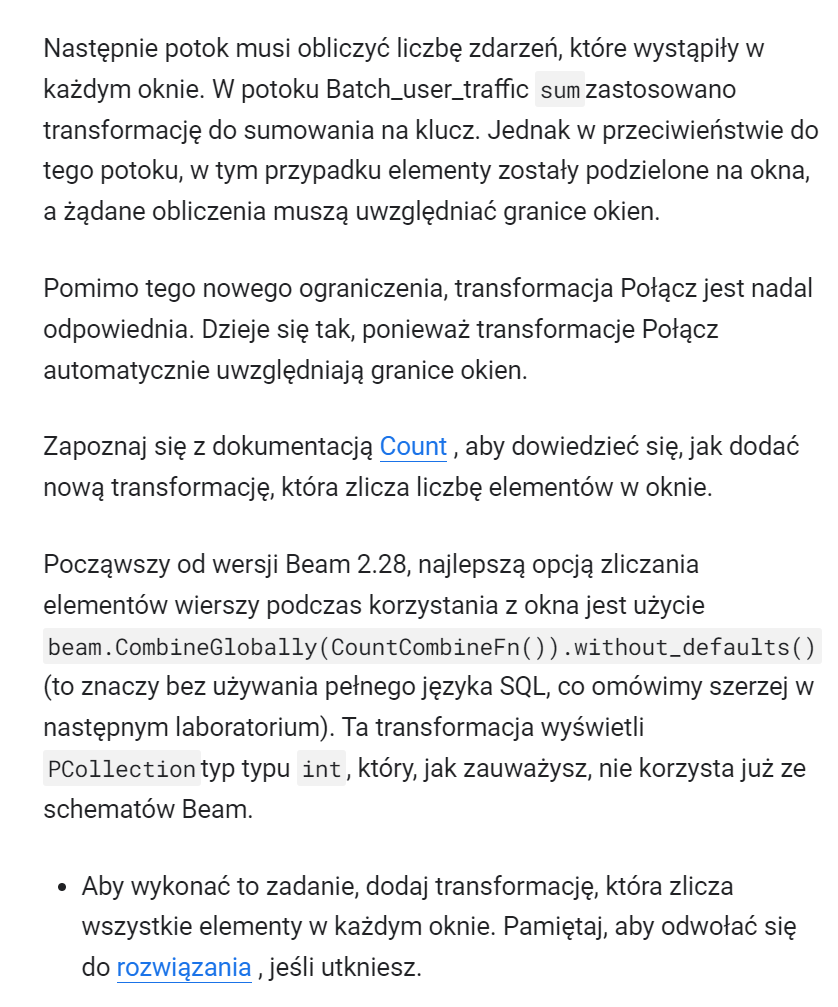

https://beam.apache.org/releases/pydoc/2.28.0/apache_beam.transforms.combiners.html#apache_beam.transforms.combiners.Count

##Zadanie 8. Przekształć z powrotem w wiersz i dodaj znacznik czasu

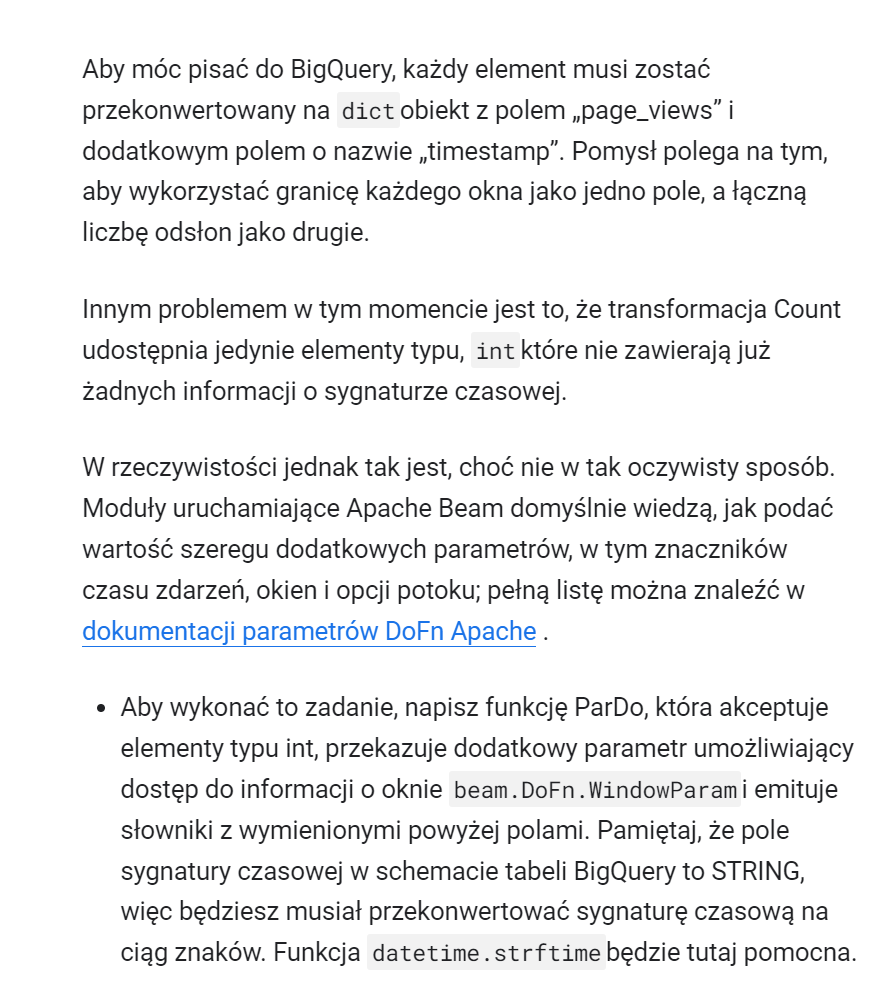

In [ ]:
class GetTimestampFn(beam.DoFn):
    def process(self, element, window=beam.DoFn.WindowParam):
        window_start = #Do something!
        output = {'page_views': element, 'timestamp': window_start}
        yield output

##Zadanie 9. Uruchom potok

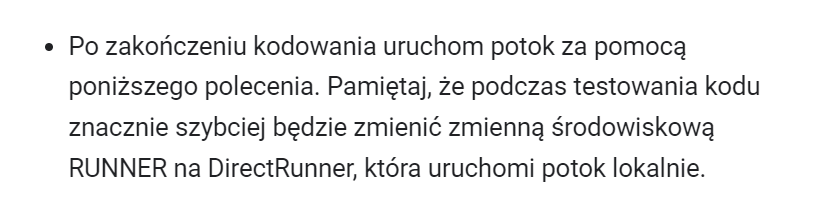

In [ ]:
export PROJECT_ID=$(gcloud config get-value project)
export REGION=us-central1
export BUCKET=gs://${PROJECT_ID}
export PIPELINE_FOLDER=${BUCKET}
export RUNNER=DataflowRunner
export INPUT_PATH=${PIPELINE_FOLDER}/events.json
export TABLE_NAME=${PROJECT_ID}:logs.minute_traffic

cd $BASE_DIR
python3 batch_minute_traffic_pipeline.py \
--project=${PROJECT_ID} \
--region=${REGION} \
--staging_location=${PIPELINE_FOLDER}/staging \
--temp_location=${PIPELINE_FOLDER}/temp \
--runner=${RUNNER} \
--input_path=${INPUT_PATH} \
--table_name=${TABLE_NAME}

batch_minute_traffic_pipeline.py

In [ ]:
import argparse
import time
import logging
import json
import typing
from datetime import datetime
import apache_beam as beam
from apache_beam.options.pipeline_options import GoogleCloudOptions
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.options.pipeline_options import StandardOptions
from apache_beam.transforms.combiners import CountCombineFn
from apache_beam.runners import DataflowRunner, DirectRunner

# ### functions and classes

class CommonLog(typing.NamedTuple):
    ip: str
    user_id: str
    lat: float
    lng: float
    timestamp: str
    http_request: str
    http_response: int
    num_bytes: int
    user_agent: str

beam.coders.registry.register_coder(CommonLog, beam.coders.RowCoder)

def parse_json(element):
    row = json.loads(element)
    return CommonLog(**row)

def add_timestamp(element):
    ts = datetime.strptime(element.timestamp[:-8], "%Y-%m-%dT%H:%M:%S").timestamp()
    return beam.window.TimestampedValue(element, ts)

class GetTimestampFn(beam.DoFn):
    def process(self, element, window=beam.DoFn.WindowParam):
        window_start = window.start.to_utc_datetime().strftime("%Y-%m-%dT%H:%M:%S")
        output = {'page_views': element, 'timestamp': window_start}
        yield output

# ### main

def run():
    # Command line arguments
    parser = argparse.ArgumentParser(description='Load from Json into BigQuery')
    parser.add_argument('--project',required=True, help='Specify Google Cloud project')
    parser.add_argument('--region', required=True, help='Specify Google Cloud region')
    parser.add_argument('--staging_location', required=True, help='Specify Cloud Storage bucket for staging')
    parser.add_argument('--temp_location', required=True, help='Specify Cloud Storage bucket for temp')
    parser.add_argument('--runner', required=True, help='Specify Apache Beam Runner')
    parser.add_argument('--input_path', required=True, help='Path to events.json')
    parser.add_argument('--table_name', required=True, help='BigQuery table name')

    opts = parser.parse_args()

    # Setting up the Beam pipeline options
    options = PipelineOptions(save_main_session=True)
    options.view_as(GoogleCloudOptions).project = opts.project
    options.view_as(GoogleCloudOptions).region = opts.region
    options.view_as(GoogleCloudOptions).staging_location = opts.staging_location
    options.view_as(GoogleCloudOptions).temp_location = opts.temp_location
    options.view_as(GoogleCloudOptions).job_name = '{0}{1}'.format('batch-minute-traffic-pipeline-',time.time_ns())
    options.view_as(StandardOptions).runner = opts.runner

    input_path = opts.input_path
    table_name = opts.table_name

    # Table schema for BigQuery
    table_schema = {
        "fields": [
            {
                "name": "page_views",
                "type": "INTEGER"
            },
            {
                "name": "timestamp",
                "type": "STRING"
            },

        ]
    }

    # Create the pipeline
    p = beam.Pipeline(options=options)



    (p | 'ReadFromGCS' >> beam.io.ReadFromText(input_path)
       | 'ParseJson' >> beam.Map(parse_json).with_output_types(CommonLog)
       | 'AddEventTimestamp' >> beam.Map(add_timestamp)
       | "WindowByMinute" >> beam.WindowInto(beam.window.FixedWindows(60))
       | "CountPerMinute" >> beam.CombineGlobally(CountCombineFn()).without_defaults()
       | "AddWindowTimestamp" >> beam.ParDo(GetTimestampFn())
       | 'WriteToBQ' >> beam.io.WriteToBigQuery(
            table_name,
            schema=table_schema,
            create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,
            write_disposition=beam.io.BigQueryDisposition.WRITE_TRUNCATE
            )
    )

    logging.getLogger().setLevel(logging.INFO)
    logging.info("Building pipeline ...")

    p.run()

if __name__ == '__main__':
  run()
